In [2]:
#import libraries
import nltk
import pandas as pd
import pysentiment as ps
import numpy as np

import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
import string
import re

from  pycorenlp import StanfordCoreNLP

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#import LMDictionary
from LMDictionary import lmdict
import matplotlib.pyplot as plt
import seaborn as sns
import time

nlp = StanfordCoreNLP('http://localhost:9000')

In [3]:
#Read Loughrin MacDonald Dictionary
df_pos = pd.read_csv('LM_PositiveWords.txt', sep="\n")
df_neg = pd.read_csv('LM_NegativeWords.txt', sep="\n", header = None)
df_lit = pd.read_csv('LM_LitigiousWords.txt', sep="\n", header = None)
lm_dict = {'Positive':df_pos,'Negative': df_neg,'Litigious':df_lit}

df_pos.columns

Index(['ABLE'], dtype='object')

In [4]:
def sentiment_with_pysentiment(dataframe, speaker,section):
    lm = ps.LM()
    df = dataframe.text_raw[(dataframe['speaker_title'].str.strip()== speaker) & (dataframe['text_type'].str.strip() == section) ]
    scores =[]
    total_pos_words = 0
    total_neg_words = 0
    total_polarity = 0
    for text in df:
        tokens = lm.tokenize(str(text))
        #tokens = word_tokenize(str(text))
        score = lm.get_score(tokens)
        scores.append(score)

    for d in scores:
        for k, v in d.items():
            if(k =='Positive'):
                total_pos_words +=v
            elif(k =='Negative'):
                total_neg_words +=v
            elif(k=='Polarity'):
                total_polarity+=v
            
    avg_polarity = total_polarity/len(scores)
    
    sentiment_category = ['positive' if avg_polarity > 0 
                          else 'negative' if avg_polarity < 0 
                              else 'neutral' ]
    
    return total_pos_words, total_neg_words, round(avg_polarity,2), sentiment_category

In [5]:
#"Very negative" = 0 "Negative" = 1 "Neutral" = 2 "Positive" = 3 "Very positive" = 4
def sentiment_with_stanfordnlp(dataframe, speaker,section):
    df = dataframe.text_raw[(dataframe['speaker_title'].str.strip()== speaker) & (dataframe['text_type'].str.strip() == section) ]
    
    total_sentiment=0
    no_of_sentences=0
    total_sentiment_score = 0
    total_avg_sentiment_score = 0
    #print(df)
    for text in df:
        #print(text)
        result=nlp.annotate(text, properties={'annotators':'sentiment','outputFormat':'json'})
    
        for s in result["sentences"]:
            sentiment_val = int(s["sentimentValue"])
            total_sentiment+=sentiment_val
            no_of_sentences+=1
        
        avg_sentiment = round(total_sentiment/no_of_sentences,2)
        total_sentiment_score +=avg_sentiment
    
    total_avg_sentiment_score = total_sentiment_score/len(df)
    
    round_sentiment_score = int(round(total_avg_sentiment_score))
    
    sentiment_score = {0:"Very negative", 1: "Negative", 2:"Neutral", 3:"Positive", 4:"Very Positive"}

        
    return sentiment_score[round_sentiment_score], total_avg_sentiment_score
    

In [6]:
def text_to_frame(filename):
    text = open(filename,'r').read()

    compname = filename.split('_')[0]
    para_list = text.splitlines()    
    text_frame = pd.DataFrame(columns=['text_type','speaker_name','speaker_affiliation','speaker_title','text_raw','text_tokens'])

    section_marker = 0
    text_type = ''
    speaker_name = ''
    speaker_affiliation = ''
    speaker_title = ''

    for p in para_list:
  
        t1 = word_tokenize(p)
    
        stopwords = ['question','questions']

        t  = [word for word in t1 if word.lower() not in stopwords]
    
        dash_list = []
        for i in range(len(t)):
            if t[i] == '--': dash_list.append(i)
        if len(dash_list) > 0:
            if dash_list[0] > 5: dash_list = []
        if len(dash_list) > 0:               
            if len(t) > 20: dash_list = []
    
        if p == 'Questions and Answers:':
            section_marker = 1
            text_type = ''
            speaker_name = ''
            speaker_affiliation = ''
            speaker_title = ''
        elif p == 'Operator':
            section_marker = 1
            text_type = ''
            speaker_name = p
            speaker_affiliation = ''
            speaker_title = ''   
        elif p == 'Unidentified Participant':
            section_marker = 1
            text_type = 'question'
            speaker_name = p
            speaker_affiliation = ''
            speaker_title = ''  
        elif len(dash_list) == 1:
            if section_marker == 0: text_type = 'general'
            else: text_type = 'answer'
            speaker_affiliation = compname
            speaker_name = ''
            speaker_title = ''
            for i in range(dash_list[0]):
                speaker_name = speaker_name + t[i] + ' '
            for j in range(dash_list[0]+1,len(t)):
                speaker_title = speaker_title + t[j] + ' '
        elif len(dash_list) == 2:
            if section_marker == 0: text_type = '?'
            else: text_type = 'question'
            speaker_name = ''
            speaker_affiliation = ''
            speaker_title = ''
            for i in range(dash_list[0]):
                speaker_name = speaker_name + t[i] + ' '
            for j in range(dash_list[0]+1,dash_list[1]):
                speaker_affiliation = speaker_affiliation + t[j] + ' '
            for k in range(dash_list[1]+1,len(t)):
                speaker_title = speaker_title + t[k] + ' '
        elif len(t) > 0:
            text_d = {'text_type':text_type,'speaker_name':speaker_name,'speaker_affiliation':speaker_affiliation,
                  'speaker_title':speaker_title,'text_raw':p,'text_tokens':t}
            text_frame = text_frame.append(text_d,ignore_index=True)
    return text_frame

In [7]:
def show_chart(graph_dict,title,ylabel, isNegative):   
    x = list(graph_dict.keys())
    y = list(graph_dict.values())

    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.axes_style('white')
    sns.set_style('white')

    colors = ['blue' if _y >=0 else 'red' for _y in y]
    ax = sns.barplot(x, y, palette=colors)

    for n, (label, _y) in enumerate(zip(x, y)):
        ax.annotate(
            s='{:.1f}'.format(abs(_y)),
            xy=(n, _y),
            ha='center',va='center',
            xytext=(0,10),
            textcoords='offset points',
            weight='bold'
        )

    if isNegative:
        ax.set(ylim=(-0.2, 1))
    else:
        ax.set(ylim=(0, 1))
    ax.set_title(title, fontdict={'fontsize':16})
    ax.set_ylabel(ylabel)
 
    ax.set_xticklabels(labels = x, rotation=90)
    
    sns.despine(ax=ax, bottom=True, left=True)

4.094589948654175


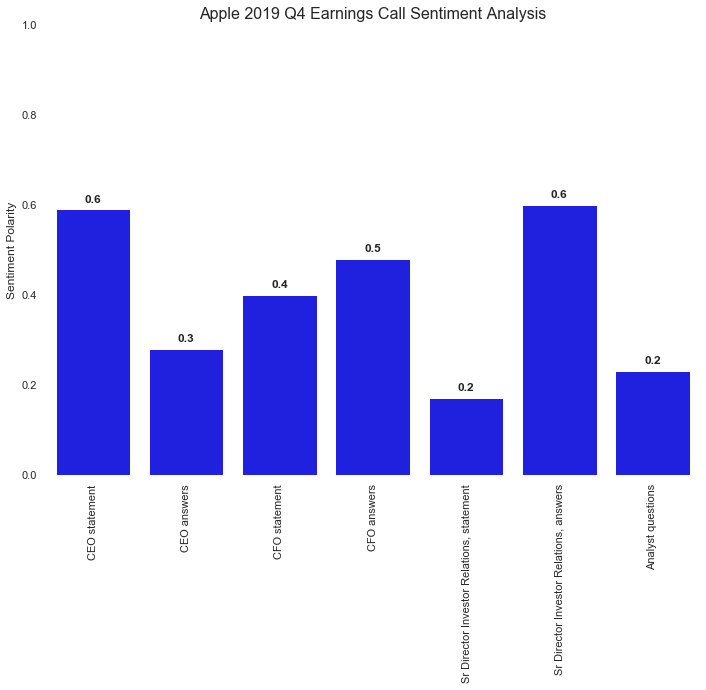

In [10]:
#Apple Q4 Results
start_time=time.time()
aapl_2019_Q4_frame = text_to_frame('AAPL_2019_Q4.txt')
aapl_graph_dict = dict()

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(aapl_2019_Q4_frame, 'Chief Executive Officer', 'general')
aapl_graph_dict.update({'CEO statement':avg_polarity})
total_pos_words, total_neg_words, avg_polarity, sentiment_score = sentiment_with_pysentiment(aapl_2019_Q4_frame, 'Chief Executive Officer', 'answer')
aapl_graph_dict.update({'CEO answers':avg_polarity})
total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(aapl_2019_Q4_frame, 'Senior Vice President & Chief Financial Officer', 'general')
aapl_graph_dict.update({'CFO statement':avg_polarity})

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(aapl_2019_Q4_frame, 'Senior Vice President & Chief Financial Officer', 'answer')
aapl_graph_dict.update({'CFO answers':avg_polarity})

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(aapl_2019_Q4_frame, 'Senior Director , Investor Relations', 'general')
aapl_graph_dict.update({'Sr Director Investor Relations, statement':avg_polarity})

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(aapl_2019_Q4_frame, 'Senior Director , Investor Relations', 'answer')
aapl_graph_dict.update({'Sr Director Investor Relations, answers':avg_polarity})

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(aapl_2019_Q4_frame, 'Analyst', 'question')

aapl_graph_dict.update({'Analyst questions':avg_polarity})

total_time = time.time()-start_time
print(total_time)
show_chart(aapl_graph_dict, 'Apple 2019 Q4 Earnings Call Sentiment Analysis', 'Sentiment Polarity', 0)



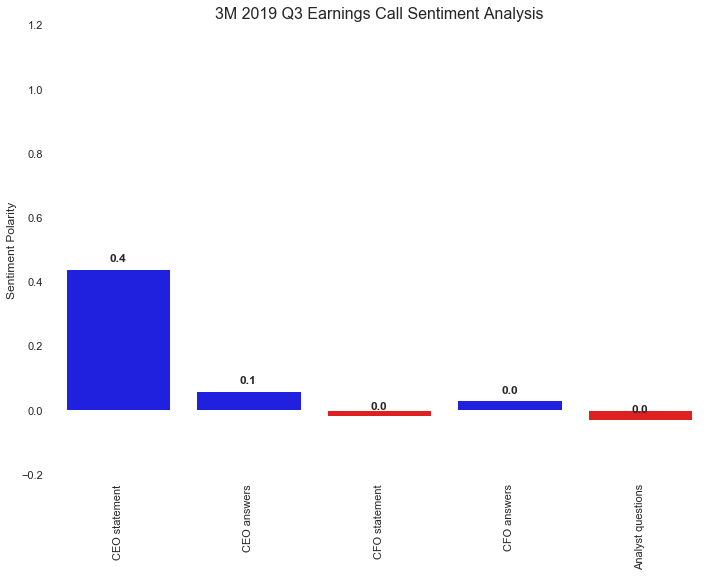

In [450]:
#3M Q3 Results
threeM_2019_Q3_frame = text_to_frame('3M_2019_Q3.txt')
threeM_graph_dict = dict()

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(threeM_2019_Q3_frame, 'Chief Executive Officer', 'general')
threeM_graph_dict.update({'CEO statement':avg_polarity})

total_pos_words, total_neg_words, avg_polarity, sentiment_score = sentiment_with_pysentiment(threeM_2019_Q3_frame, 'Chief Executive Officer', 'answer')
threeM_graph_dict.update({'CEO answers':avg_polarity})

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(threeM_2019_Q3_frame, 'Senior Vice President and Chief Financial Officer', 'general')
threeM_graph_dict.update({'CFO statement':avg_polarity})

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(threeM_2019_Q3_frame, 'Senior Vice President and Chief Financial Officer', 'answer')
threeM_graph_dict.update({'CFO answers':avg_polarity})

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(threeM_2019_Q3_frame, 'Analyst', 'question')
threeM_graph_dict.update({'Analyst questions':avg_polarity})

show_chart(threeM_graph_dict, '3M 2019 Q3 Earnings Call Sentiment Analysis', 'Sentiment Polarity',1)

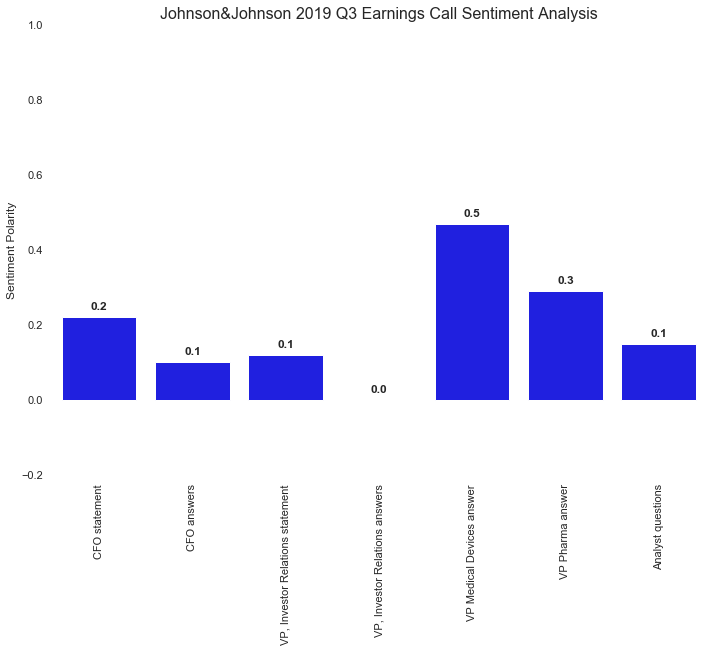

In [480]:
#JNJ Q3 Results
JNJ_2019_Q3_frame = text_to_frame('JNJ_2019_Q3.txt')
''''print(JNJ_2019_Q3_frame['text_type'].value_counts())
print(JNJ_2019_Q3_frame['speaker_name'].value_counts())
print(JNJ_2019_Q3_frame['speaker_affiliation'].value_counts())
print(JNJ_2019_Q3_frame['speaker_title'].value_counts())
'''
JNJ_graph_dict = dict()

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(JNJ_2019_Q3_frame, 'Executive Vice President and Chief Financial Officer', 'general')
JNJ_graph_dict.update({'CFO statement':avg_polarity})

total_pos_words, total_neg_words, avg_polarity, sentiment_score = sentiment_with_pysentiment(JNJ_2019_Q3_frame, 'Executive Vice President and Chief Financial Officer', 'answer')
JNJ_graph_dict.update({'CFO answers':avg_polarity})

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(JNJ_2019_Q3_frame, 'Vice President of Investor Relations', 'general')
JNJ_graph_dict.update({'VP, Investor Relations statement':avg_polarity})

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(JNJ_2019_Q3_frame, 'Vice President of Investor Relations', 'answer')
JNJ_graph_dict.update({'VP, Investor Relations answers':avg_polarity})

#total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(JNJ_2019_Q3_frame, 'Executive Vice President , Worldwide Chairman , Medical Devices', 'general')
#JNJ_graph_dict.update({'VP Medical Devices statement':avg_polarity})
total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(JNJ_2019_Q3_frame, 'Executive Vice President , Worldwide Chairman , Medical Devices', 'answer')
JNJ_graph_dict.update({'VP Medical Devices answer':avg_polarity})


#total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(JNJ_2019_Q3_frame, 'Executive Vice President , Worldwide Chairman , Pharmaceuticals', 'general')
#JNJ_graph_dict.update({'VP Pharma statement':avg_polarity})
total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(JNJ_2019_Q3_frame, 'Executive Vice President , Worldwide Chairman , Pharmaceuticals', 'answer')
JNJ_graph_dict.update({'VP Pharma answer':avg_polarity})

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(JNJ_2019_Q3_frame, 'Analyst', 'question')
JNJ_graph_dict.update({'Analyst questions':avg_polarity})

show_chart(JNJ_graph_dict, 'Johnson&Johnson 2019 Q3 Earnings Call Sentiment Analysis', 'Sentiment Polarity',1)

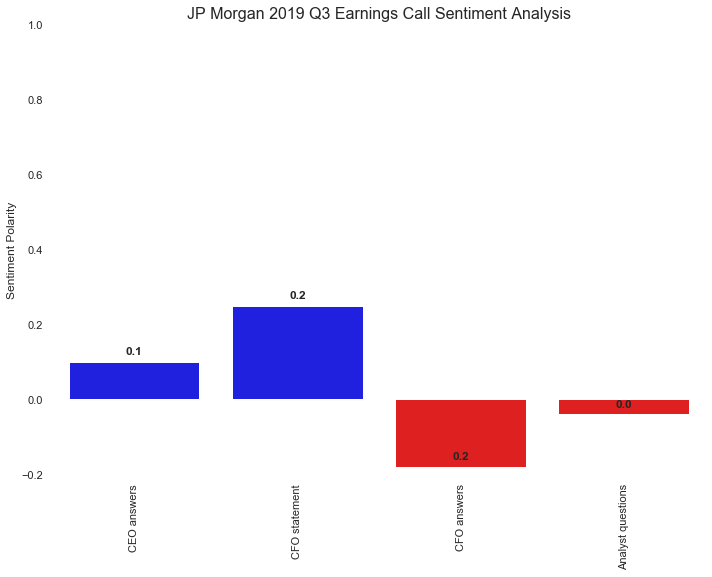

In [479]:
#JPM Q3 Results
JPM_2019_Q3_frame = text_to_frame('JPM_2019_Q3.txt')
'''print(JPM_2019_Q3_frame['text_type'].value_counts())
print(JPM_2019_Q3_frame['speaker_name'].value_counts())
print(JPM_2019_Q3_frame['speaker_affiliation'].value_counts())
print(JPM_2019_Q3_frame['speaker_title'].value_counts())
'''
JPM_graph_dict = dict()

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(JPM_2019_Q3_frame, 'Chairman and Chief Executive Officer', 'answer')
JPM_graph_dict.update({'CEO answers':avg_polarity})

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(JPM_2019_Q3_frame, 'Chief Financial Officer', 'general')
JPM_graph_dict.update({'CFO statement':avg_polarity})

total_pos_words, total_neg_words, avg_polarity, sentiment_score = sentiment_with_pysentiment(JPM_2019_Q3_frame, 'Chief Financial Officer', 'answer')
JPM_graph_dict.update({'CFO answers':avg_polarity})



total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(JPM_2019_Q3_frame, 'Analyst', 'question')
JPM_graph_dict.update({'Analyst questions':avg_polarity})

show_chart(JPM_graph_dict, 'JP Morgan 2019 Q3 Earnings Call Sentiment Analysis', 'Sentiment Polarity',1)

general     60
answer      31
question    17
            12
Name: text_type, dtype: int64
Amy E. Hood         41
Satya Nadella       36
Michael Spencer     14
Operator             9
Keith Weiss          3
                     3
Heather Bellini      2
Philip Winslow       2
Karl Keirstead       2
Jennifer Lowe        2
Raimo Lenschow       2
Brent Thill          2
Mark Moerdler        2
Name: speaker_name, dtype: int64
MSFT                       91
                           12
Morgan Stanley              3
Jefferies                   2
Goldman Sachs               2
Bernstein Research          2
Wells Fargo Securities      2
Deutsche Bank               2
Barclays Capital            2
UBS                         2
Name: speaker_affiliation, dtype: int64
Chief Financial Officer                   41
Chief Executive Officer                   36
Analyst                                   17
General Manager of Investor Relations     14
                                          12
Name: speaker

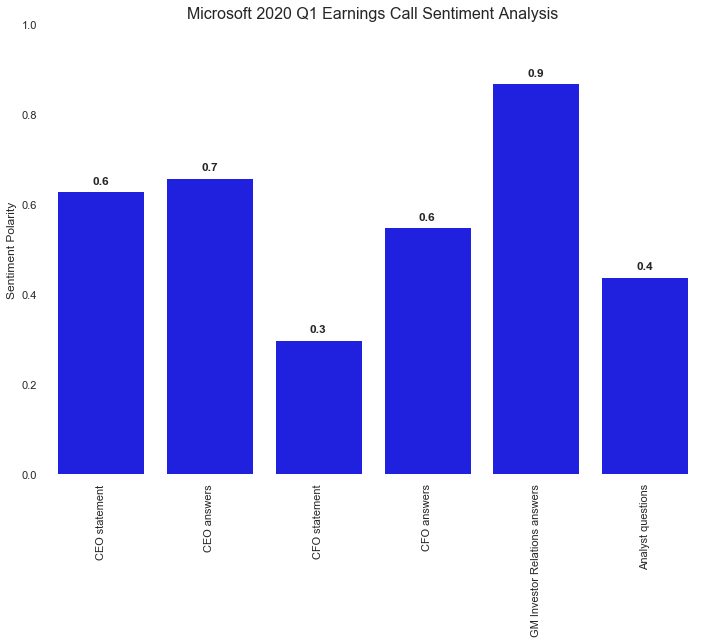

In [461]:
#MSFT 2020 Q1 Results
MSFT_2020_Q1_frame = text_to_frame('MSFT_2020_Q1.txt')
print(MSFT_2020_Q1_frame['text_type'].value_counts())
print(MSFT_2020_Q1_frame['speaker_name'].value_counts())
print(MSFT_2020_Q1_frame['speaker_affiliation'].value_counts())
print(MSFT_2020_Q1_frame['speaker_title'].value_counts())

MSFT_graph_dict = dict()

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(MSFT_2020_Q1_frame, 'Chief Executive Officer', 'general')
MSFT_graph_dict.update({'CEO statement':avg_polarity})

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(MSFT_2020_Q1_frame, 'Chief Executive Officer', 'answer')
MSFT_graph_dict.update({'CEO answers':avg_polarity})

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(MSFT_2020_Q1_frame, 'Chief Financial Officer', 'general')
MSFT_graph_dict.update({'CFO statement':avg_polarity})

total_pos_words, total_neg_words, avg_polarity, sentiment_score = sentiment_with_pysentiment(MSFT_2020_Q1_frame, 'Chief Financial Officer', 'answer')
MSFT_graph_dict.update({'CFO answers':avg_polarity})

total_pos_words, total_neg_words, avg_polarity, sentiment_score = sentiment_with_pysentiment(MSFT_2020_Q1_frame, 'General Manager of Investor Relations', 'answer')
MSFT_graph_dict.update({'GM Investor Relations answers':avg_polarity})


total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(MSFT_2020_Q1_frame, 'Analyst', 'question')
MSFT_graph_dict.update({'Analyst questions':avg_polarity})

show_chart(MSFT_graph_dict, 'Microsoft 2020 Q1 Earnings Call Sentiment Analysis', 'Sentiment Polarity',0)

general     81
answer      71
question    38
            16
Name: text_type, dtype: int64
Doug McMillon      79
Brett Biggs        68
Operator           14
Scott Mushkin       5
Dan Binder          5
Oliver Chen         4
Simeon Gutman       4
Karen Short         3
Michael Lasser      3
Bob Drbul           3
Seth Sigman         3
Edward Kelly        2
Charles Grom        2
Paul Trussell       2
Peter Benedict      2
Kelly Bania         2
Robbie Ohmes        2
                    2
Edward Yruma        1
Name: speaker_name, dtype: int64
WMT                               152
                                   16
Wolfe Research                      5
Cowen & Company                     4
Morgan Stanley                      4
UBS                                 3
Guggenheim Securities               3
Barclays                            3
Credit Suisse                       3
BMO Capital Markets                 2
Wells Fargo                         2
Gordon Haskett                      2
Bai

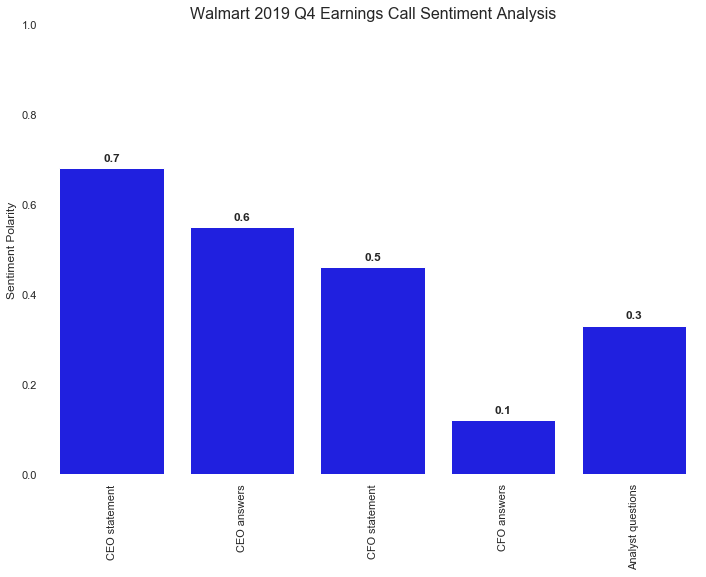

In [462]:
#WMT 2019 Q4 Results
WMT_2019_Q4_frame = text_to_frame('WMT_2019_Q4.txt')
print(WMT_2019_Q4_frame['text_type'].value_counts())
print(WMT_2019_Q4_frame['speaker_name'].value_counts())
print(WMT_2019_Q4_frame['speaker_affiliation'].value_counts())
print(WMT_2019_Q4_frame['speaker_title'].value_counts())

WMT_graph_dict = dict()

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(WMT_2019_Q4_frame, 'President and Chief Executive Officer', 'general')
WMT_graph_dict.update({'CEO statement':avg_polarity})

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(WMT_2019_Q4_frame, 'President and Chief Executive Officer', 'answer')
WMT_graph_dict.update({'CEO answers':avg_polarity})

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(WMT_2019_Q4_frame, 'Executive Vice President and Chief Financial Officer', 'general')
WMT_graph_dict.update({'CFO statement':avg_polarity})

total_pos_words, total_neg_words, avg_polarity, sentiment_score = sentiment_with_pysentiment(WMT_2019_Q4_frame, 'Executive Vice President and Chief Financial Officer', 'answer')
WMT_graph_dict.update({'CFO answers':avg_polarity})

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(WMT_2019_Q4_frame, 'Analyst', 'question')
WMT_graph_dict.update({'Analyst questions':avg_polarity})

show_chart(WMT_graph_dict, 'Walmart 2019 Q4 Earnings Call Sentiment Analysis', 'Sentiment Polarity',0)

#Using Stanford NLP

In [10]:
start_time = time.time()
aapl_2019_Q4_frame = text_to_frame('AAPL_2019_Q4.txt')
sentiment_value, total_avg_sentiment_score = sentiment_with_stanfordnlp(aapl_2019_Q4_frame, 'Chief Executive Officer', 'general')
print(time.time()-start_time)
print("Apple CEO: Metrics for general statements :" ,sentiment_value, total_avg_sentiment_score)

19.853676080703735
Apple CEO: Metrics for general statements : Neutral 1.9012499999999999


In [11]:
sentiment_value, total_avg_sentiment_score = sentiment_with_stanfordnlp(aapl_2019_Q4_frame, 'Chief Executive Officer', 'answer')
print("Apple CEO: Metrics for answers statements :" ,sentiment_value, total_avg_sentiment_score)

Apple CEO: Metrics for answers statements : Neutral 2.0213333333333336


In [12]:
sentiment_value, total_avg_sentiment_score = sentiment_with_stanfordnlp(aapl_2019_Q4_frame, 'Analyst', 'question')
print("Apple Analyst: Metrics for question statements :" ,sentiment_value, total_avg_sentiment_score)

Apple Analyst: Metrics for question statements : Neutral 2.0125


    #Sentiment analysis for NIO stocks

In [14]:
NIO_2019_Q1_frame = text_to_frame('NIO_Q1_2019.txt')
NIO_2019_Q1_frame.head()

,text_type,speaker_name,speaker_affiliation,speaker_title,text_raw,text_tokens
0,general,Jade Wei,NIO,Senior Director of Investor Relations,"Thank you, Annie. Good evening, and good morni...","[Thank, you, ,, Annie, ., Good, evening, ,, an..."
1,general,Jade Wei,NIO,Senior Director of Investor Relations,"On today's call, we have Mr. William Li, found...","[On, today, 's, call, ,, we, have, Mr., Willia..."
2,general,Jade Wei,NIO,Senior Director of Investor Relations,David and Tom just revealed what they believe ...,"[David, and, Tom, just, revealed, what, they, ..."
3,general,Jade Wei,NIO,Senior Director of Investor Relations,Louis is joining us by telephone from the Unit...,"[Louis, is, joining, us, by, telephone, from, ..."
4,general,Jade Wei,NIO,Senior Director of Investor Relations,"As such, the company's actual results may be m...","[As, such, ,, the, company, 's, actual, result..."


In [15]:
print(NIO_2019_Q1_frame['text_type'].value_counts())
print(NIO_2019_Q1_frame['speaker_name'].value_counts())
print(NIO_2019_Q1_frame['speaker_affiliation'].value_counts())
print(NIO_2019_Q1_frame['speaker_title'].value_counts())

answer      62
general     36
question    17
             7
Name: text_type, dtype: int64
Louis Hsieh     33
Jade Wei        32
Nick Wang       19
William Li      14
Operator         7
Paul Gong        5
Yin Ling         3
Wei Feng         3
Bin Wang         3
Dan Galves       2
Fei Fang         1
Name: speaker_name, dtype: int64
NIO                98
                    7
UBS                 5
Credit Suisse       3
Deutsche Bank       3
CICC                3
Wolfe Research      2
Goldman Sachs       1
Name: speaker_affiliation, dtype: int64
Chief Financial Officer                                           33
Senior Director of Investor Relations                             32
Vice President of Finance                                         19
Analyst                                                           17
Founder , Chairman of the Board , and Chief Executive Officer     14
                                                                   7
Name: speaker_title, dtype: int64


In [16]:
sentiment_value, total_avg_sentiment_score = sentiment_with_stanfordnlp(NIO_2019_Q1_frame, 'Analyst', 'question')
print("NIO analyst: Metrics for questions :" ,sentiment_value, total_avg_sentiment_score)

NIO analyst: Metrics for questions : Neutral 1.9288235294117646


In [17]:
sentiment_value, total_avg_sentiment_score = sentiment_with_stanfordnlp(NIO_2019_Q1_frame, 'Vice President of Finance', 'answer')
print("NIO analyst: Metrics for questions :" ,sentiment_value, total_avg_sentiment_score)

NIO analyst: Metrics for questions : Neutral 2.01875


In [18]:
total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(NIO_2019_Q1_frame, 'Analyst', 'question')
print("NIO Analyst: Metrics for questions :",total_pos_words, total_neg_words, avg_polarity, sentiment_score)

NIO Analyst: Metrics for questions : 5 7 -0.08 ['negative']


In [19]:
total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(NIO_2019_Q1_frame, 'Vice President of Finance', 'answer')
print("NIO Analyst: Metrics for questions :",total_pos_words, total_neg_words, avg_polarity, sentiment_score)

NIO Analyst: Metrics for questions : 2.0 6.0 -0.08 ['negative']


    #Graphs

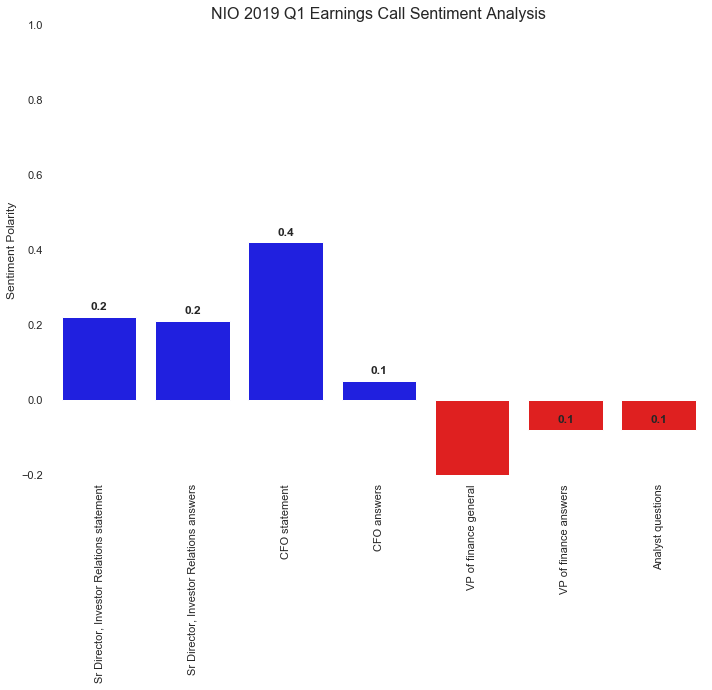

In [20]:
NIO_graph_dict = dict()

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(NIO_2019_Q1_frame, 'Senior Director of Investor Relations', 'general')
NIO_graph_dict.update({'Sr Director, Investor Relations statement':avg_polarity})

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(NIO_2019_Q1_frame, 'Senior Director of Investor Relations', 'answer')
NIO_graph_dict.update({'Sr Director, Investor Relations answers':avg_polarity})

total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(NIO_2019_Q1_frame, 'Chief Financial Officer', 'general')
NIO_graph_dict.update({'CFO statement':avg_polarity})

total_pos_words, total_neg_words, avg_polarity, sentiment_score = sentiment_with_pysentiment(NIO_2019_Q1_frame, 'Chief Financial Officer', 'answer')
NIO_graph_dict.update({'CFO answers':avg_polarity})

total_pos_words, total_neg_words, avg_polarity, sentiment_score = sentiment_with_pysentiment(NIO_2019_Q1_frame, 'Vice President of Finance', 'general')
NIO_graph_dict.update({'VP of finance general':avg_polarity})

total_pos_words, total_neg_words, avg_polarity, sentiment_score = sentiment_with_pysentiment(NIO_2019_Q1_frame, 'Vice President of Finance', 'answer')
NIO_graph_dict.update({'VP of finance answers':avg_polarity})


total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(NIO_2019_Q1_frame, 'Analyst', 'question')
NIO_graph_dict.update({'Analyst questions':avg_polarity})

show_chart(NIO_graph_dict, 'NIO 2019 Q1 Earnings Call Sentiment Analysis', 'Sentiment Polarity',1)

In [287]:

threeM_2019_Q3_frame.head()
print(threeM_2019_Q3_frame['text_type'].value_counts())
print(threeM_2019_Q3_frame['speaker_name'].value_counts())
print(threeM_2019_Q3_frame['speaker_affiliation'].value_counts())
print(threeM_2019_Q3_frame['speaker_title'].value_counts())

answer      74
question    54
general     42
            12
Name: text_type, dtype: int64
Nicholas Gangestad     57
Michael F. Roman       54
Operator               12
John Inch               7
Steve Tusa              6
Nigel Coe               6
Scott Davis             5
John Walsh              5
Joe Ritchie             5
Andrew Obin             5
Bruce Jermeland         5
Andrew Kaplowitz        4
Deane Dray              4
Julian Mitchell         4
Laurence Alexander      3
Name: speaker_name, dtype: int64
3M                                116
                                   12
Gordon Haskett                      7
JP Morgan                           6
Wolfe Research                      6
Goldman Sachs                       5
Credit Suisse                       5
Bank of America Merrill Lynch       5
Melius Research                     5
Barclays                            4
RBC Capital Markets                 4
Citi                                4
Jefferies & Company            

In [281]:
sentiment_value, total_avg_sentiment_score = sentiment_with_stanfordnlp(threeM_2019_Q3_frame, 'Analyst', 'question')
print("3M analyst: Metrics for questions :" ,sentiment_value, total_avg_sentiment_score)

3M analyst: Metrics for questions : Neutral 1.87037037037037


In [283]:
total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(threeM_2019_Q3_frame, 'Analyst', 'question')
print("3m Analyst: Metrics for questions :",total_pos_words, total_neg_words, avg_polarity, sentiment_score)

3m Analyst: Metrics for questions : 17 21 -0.03 ['negative']


In [289]:
total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(threeM_2019_Q3_frame, 'Senior Vice President and Chief Financial Officer', 'general')
print("3M Analyst: Metrics for questions :",total_pos_words, total_neg_words, avg_polarity, sentiment_score)

3M Analyst: Metrics for questions : 22 26 -0.02 ['negative']


In [292]:
total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(threeM_2019_Q3_frame, 'Senior Vice President and Chief Financial Officer', 'answer')
print("3M Analyst: Metrics for questions :",total_pos_words, total_neg_words, avg_polarity, sentiment_score)

3M Analyst: Metrics for questions : 30 18 0.03 ['positive']


In [290]:
total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(threeM_2019_Q3_frame, 'Chief Executive Officer', 'general')
print("3M Analyst: Metrics for questions :",total_pos_words, total_neg_words, avg_polarity, sentiment_score)

3M Analyst: Metrics for questions : 47 14 0.44 ['positive']


In [291]:
total_pos_words, total_neg_words, avg_polarity,sentiment_score = sentiment_with_pysentiment(threeM_2019_Q3_frame, 'Chief Executive Officer', 'answer')
print("3M Analyst: Metrics for questions :",total_pos_words, total_neg_words, avg_polarity, sentiment_score)

3M Analyst: Metrics for questions : 43.0 21.0 0.06 ['positive']
